In [3]:
import copy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
import bcolz
import tensorflow as tf
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import gensim

In [72]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import warnings
import pickle

warnings.filterwarnings('ignore')

data = pd.read_csv("AIDEA_Train2_p.txt", sep='\t',encoding = 'utf-8')

dev_data = pd.read_csv("AIDEA_Dev2_p.txt",sep = '\t',encoding = 'utf-8')
dev_data

0  1  Sentence#
0      醫師  O          1
1       ：  O          1
2       你  O          1
3       有  O          1
4       做  O          1
...    .. ..        ...
34222  外頭  O       2804
34223   稍  O       2804
34224   坐  O       2804
34225  一下  O       2804
34226   。  O       2804

[34227 rows x 3 columns]

### 如果已經跑過 下次可以不用執行

In [73]:
# emb_words = []
# emb_idx = 0
# emb_word2idx = {}
# emb_vectors = bcolz.carray(np.zeros(1), rootdir='./word_embedding/zh_T.dat', mode='w')

# with open(f'./zh_T.tsv', 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         emb_words.append(word)
#         emb_word2idx[word] = emb_idx
#         emb_idx += 1
#         vect = np.array(line[1:]).astype(np.float)
#         emb_vectors.append(vect)
        
# emb_vectors = bcolz.carray(emb_vectors[1:].reshape((50101, -1)), rootdir='./word_embedding/zh_T.dat', mode='w')
# emb_vectors.flush()
# pickle.dump(emb_words, open('./word_embedding/zh_T_words.pkl', 'wb'))
# pickle.dump(emb_word2idx, open('./word_embedding/zh_T_idx.pkl', 'wb'))

In [74]:
emb_vectors = bcolz.open('./word_embedding/zh_T.dat')[:]
emb_words = pickle.load(open('./word_embedding/zh_T_words.pkl', 'rb'))
emb_word2idx = pickle.load(open('./word_embedding/zh_T_idx.pkl', 'rb'))

In [75]:
embedd = {w: emb_vectors[emb_word2idx[w]] for w in emb_words}

In [76]:
embedd

{'的': array([-1.18296301e+00, -2.30984733e-01, -1.86338678e-01, -3.79195392e-01,
        -2.53845930e-01,  6.32365882e-01, -7.33441532e-01, -7.62261093e-01,
         2.29022607e-01,  7.29447186e-01,  1.70743048e+00, -6.15516245e-01,
        -4.14229721e-01, -9.21701670e-01, -9.57892478e-01,  7.53816962e-01,
         8.52156401e-01,  6.70360088e-01, -8.53230953e-01,  2.89767534e-01,
        -4.46276784e-01,  9.55550745e-02, -4.25439984e-01,  4.57545996e-01,
         1.61597922e-01,  1.18851244e+00,  5.15118361e-01, -1.46450832e-01,
        -1.70009315e+00,  3.44248205e-01,  2.07040000e+00, -4.51246232e-01,
        -3.86089385e-01, -1.56344092e+00,  5.82406402e-01, -1.14859664e+00,
         1.32758832e+00,  1.58303821e+00, -9.62366402e-01,  3.51475626e-01,
        -7.28380322e-01, -9.24934521e-02,  3.13577652e-01,  7.18484223e-01,
        -2.43689895e-01,  8.46931458e-01, -9.77777779e-01,  4.93179798e-01,
         2.51347125e-01,  1.76386073e-01, -2.28666008e-01,  4.38425809e-01,
       

In [9]:
words = list(set(data['0'].values))
words.append("ENDPAD")
words.append("unk")

In [10]:
n_words = len(words); n_words
tags = list(set(data['1'].values))
# tags.append("ENDPAD")
n_tags = len(tags); n_tags

25

In [11]:
tags

['I-time',
 'I-med_exam',
 'I-location',
 'B-profession',
 'B-location',
 'B-others',
 'O',
 'B-med_exam',
 'B-name',
 'I-family',
 'B-family',
 'I-name',
 'B-ID',
 'I-contact',
 'B-money',
 'I-education',
 'B-contact',
 'B-clinical_event',
 'B-organization',
 'B-time',
 'B-education',
 'I-profession',
 'I-others',
 'I-ID',
 'I-money']

In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["0"].values.tolist(),
                                                     s["1"].values.tolist())]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(data)
dev_getter = SentenceGetter(dev_data)

In [14]:
sent = getter.get_next()
dev_sent = dev_getter.get_next()
dev_sent

[('醫師', 'O'),
 ('：', 'O'),
 ('你', 'O'),
 ('有', 'O'),
 ('做', 'O'),
 ('超音波', 'O'),
 ('嘛', 'O'),
 ('，', 'O'),
 ('那', 'O'),
 ('我們', 'O'),
 ('來', 'O'),
 ('看', 'O'),
 ('報告', 'O'),
 ('，', 'O'),
 ('有', 'O'),
 ('些', 'O'),
 ('部分', 'O'),
 ('有', 'O'),
 ('紅字', 'O'),
 ('耶', 'O'),
 ('。', 'O')]

In [15]:
sentences = getter.sentences
dev_sentences = dev_getter.sentences
len(sentences)

25572

In [16]:
max_len = 400
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}

In [17]:
from keras.preprocessing.sequence import pad_sequences
dev_X = []
for s in dev_sentences:
  b = []
  for w in s:
    try:
      b.append(word2idx[w[0]])
    except:
      b.append(word2idx['unk'])
  dev_X.append(b)
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [18]:
X = pad_sequences(maxlen=max_len, dtype="long", sequences=X, padding="post", value=word2idx['ENDPAD'])
dev_X = pad_sequences(maxlen=max_len, dtype="long", sequences=dev_X, padding="post", value=word2idx['ENDPAD'])

In [19]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

dev_y = []
for s in dev_sentences:
  b = []
  for w in s:
    try:
      b.append(tag2idx[w[1]])
    except:
      b.append(tag2idx['O'])
  dev_y.append(b)

In [20]:
y = pad_sequences(maxlen=max_len , dtype="int32", sequences=y, padding="post", value=tag2idx["O"])
dev_y = pad_sequences(maxlen=max_len, dtype="int32", sequences=dev_y, padding="post", value=tag2idx["O"])

In [21]:
def convert_to_one_hot(Y, C):
    Y_oh = [np.eye(C)[i].astype(np.float32) for i in Y]
    return Y_oh
batch_y = convert_to_one_hot(y,n_tags)
batch_dev_y = convert_to_one_hot(dev_y,n_tags)

In [35]:
from torch.utils.data import TensorDataset, DataLoader
bs = 64

tr_inputs = torch.LongTensor(X)
val_inputs = torch.LongTensor(dev_X)
tr_tags = torch.tensor(batch_y)
val_tags = torch.tensor(batch_dev_y)

print('tr_inputs',tr_inputs.size(),tr_inputs.type())
print('val_inputs',val_inputs.size())
print('tr_tags',tr_tags.size(),tr_tags.type())
print('val_tags',val_tags.size())

train_data = TensorDataset(tr_inputs, tr_tags)
train_dataloader = DataLoader(train_data, batch_size=bs
                              # ,shuffle=True
                              )

valid_data = TensorDataset(val_inputs, val_tags)
valid_dataloader = DataLoader(valid_data,  batch_size=bs)

tr_inputs torch.Size([25572, 400]) torch.LongTensor
val_inputs torch.Size([2804, 400])
tr_tags torch.Size([25572, 400, 25]) torch.FloatTensor
val_tags torch.Size([2804, 400, 25])


In [36]:
all_dataloader = {
    'train' : train_dataloader,
    'valid' : valid_dataloader,
}
for i in all_dataloader:
    print(i)

train
valid


In [37]:
class EmbeddedRnn(nn.Module):
    def __init__(self, vocab, hidden_dim, output_vocab,pad_idx, n_layer=2):
        super(EmbeddedRnn, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.embedding_size = 300
        self.embedded = nn.Embedding(vocab, self.embedding_size , padding_idx  = pad_idx)
        self.lstm = nn.GRU(self.embedding_size, hidden_dim, num_layers=n_layer,batch_first = True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden_dim, output_vocab)
        self.softmax = nn.Softmax(dim=-1)
        self.relu = nn.ReLU()
    
    def forward(self, x, hidden):
        embedded = self.embedded(x)
        # print(embedded.shape)
        output, hidden = self.lstm(embedded, hidden)
        # print(output.shape,hidden.shape)
        output = self.fc1(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self, batch_size):
        hidden = Variable(torch.zeros(2 * self.n_layer, batch_size, self.hidden_dim))
        # cell = Variable(torch.zeros(2 * self.n_layer, batch_size, self.hidden_dim))
        # return [hidden, cell]
        return hidden

In [38]:
matrix_len = len(words)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(words):
    try: 
        weights_matrix[i] = embedd[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
print('not in the corpus : ',words_found)

In [40]:
weights_matrix = torch.tensor(weights_matrix)
weights_matrix.size()

torch.Size([7579, 300])

In [42]:
use_cuda = torch.cuda.is_available()
model = EmbeddedRnn(len(words), 64, n_tags,word2idx['ENDPAD'])
if use_cuda:
    print('use_cuda')
    model = model.cuda(0)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

num_epoch = 10

use_cuda


In [43]:
model.embedded.weight.data.copy_(weights_matrix)
model.embedded.weight.requires_grad = True

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


train_loss : 0.002101478269250947
train_F1: 0.0265685019206146
valid_loss : 0.00020966423976047238


 10%|████████▎                                                                          | 1/10 [00:28<04:20, 28.96s/it]

valid_F1: 0.13029315960912052

train_loss : 0.00015277534500910406
train_F1: 0.261240564489662
valid_loss : 0.00014023655653132167


 20%|████████████████▌                                                                  | 2/10 [00:59<03:54, 29.34s/it]

valid_F1: 0.2905317769130999

train_loss : 0.00011178359830864793
train_F1: 0.4056970220112215
valid_loss : 0.00011535749469906229


 30%|████████████████████████▉                                                          | 3/10 [01:27<03:24, 29.17s/it]

valid_F1: 0.3845223700120919

train_loss : 9.063730156981364e-05
train_F1: 0.46578428611658684
valid_loss : 0.0001008647767031851


 40%|█████████████████████████████████▏                                                 | 4/10 [01:56<02:54, 29.05s/it]

valid_F1: 0.4489311163895487

train_loss : 7.550655700867992e-05
train_F1: 0.5117047645276782
valid_loss : 9.012200313339814e-05


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:26<02:26, 29.20s/it]

valid_F1: 0.495260663507109

train_loss : 6.372944276961334e-05
train_F1: 0.5732776055008763
valid_loss : 8.261433500096742e-05


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:55<01:56, 29.19s/it]

valid_F1: 0.5714285714285714

train_loss : 5.41870017070778e-05
train_F1: 0.6619028715098584
valid_loss : 7.783551100973537e-05


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:24<01:27, 29.17s/it]

valid_F1: 0.6064814814814814

train_loss : 4.6038321574144444e-05
train_F1: 0.7105022831050227
valid_loss : 7.523907821781573e-05


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:53<00:58, 29.18s/it]

valid_F1: 0.6265895953757225

train_loss : 3.882376409805488e-05
train_F1: 0.7442220787604905
valid_loss : 7.396695897651543e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:22<00:29, 29.18s/it]

valid_F1: 0.6534883720930232

train_loss : 3.246727263288563e-05
train_F1: 0.7692702321405669
valid_loss : 7.323618322888333e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.27s/it]

valid_F1: 0.6783216783216783


              precision    recall  f1-score   support

    location       0.59      0.61      0.60        36
    med_exam       0.42      0.81      0.55        59
       money       0.00      0.00      0.00        32
        name       0.68      0.83      0.75        23
organization       0.00      0.00      0.00         5
  profession       0.00      0.00      0.00         2
        time       0.88      0.70      0.78       289

   micro avg       0.71      0.65      0.68       446
   macro avg       0.37      0.42      0.38       446
weighted avg       0.71      0.65      0.66       446

0.6783216783216783


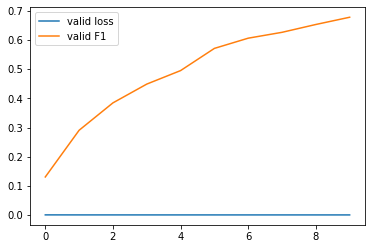

In [44]:
records = {
    'loss':[],
    'F1':[],
}
model.train(True)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in tqdm(range(num_epoch)):
    # train_loss,valid_loss = [],[]
    all_loss = {
        'train': [],
        'valid': [],
    }
    print('')
    for loader in all_dataloader:
        predictions , true_labels , x_  = [],[],[]
        for x, y in all_dataloader[loader]:
            optimizer.zero_grad()
            x = x.cuda(0) if use_cuda else x
            y = y.cuda(0) if use_cuda else y
            hidden = model.initHidden(x.size(0))
            if use_cuda:
                # hidden[0] = hidden[0].cuda(0)
                # hidden[1] = hidden[1].cuda(0)
                hidden = hidden.cuda(0)
            output, hidden = model(x, hidden)
    
            loss = criterion(output,y)

            if loader == 'train':
                loss.backward()
                optimizer.step()
            all_loss[loader].append(loss.cpu().item()) 

            x_.extend(x.detach().cpu().numpy())
            predictions.extend(np.argmax(output.detach().cpu().numpy(), axis=2))
            true_labels.extend(np.argmax(y.detach().cpu().numpy(), axis=2))
        print(f'{loader}_loss : {np.mean(np.array(all_loss[loader]))}')
        pred_tags = [idx2tag[p_i] for p, l , __ in zip(predictions, true_labels,x_) for p_i, l_i ,_i in zip(p, l,__) if idx2word[_i] != "ENDPAD"]
    
        valid_tags = [idx2tag[l_i] for l, __ in zip(true_labels,x_) for l_i,_i in zip(l,__) if idx2word[_i] != "ENDPAD"]
        f_ = f1_score([valid_tags],[pred_tags])
        print(f'{loader}_F1: {f_}')
        if loader == 'valid':
            records['loss'].append(np.mean(np.array(all_loss[loader])))
            records['F1'].append(f_)
        if loader == 'valid' and f_ > best_acc:
            best_acc = f_
            best_model_wts = copy.deepcopy(model.state_dict())

# records = np.array(records)
print(classification_report([valid_tags],[pred_tags]))
print(best_acc)
plt.plot(np.array(records['loss']), label='valid loss')
plt.plot(np.array(records['F1']), label='valid F1')
plt.legend()
plt.show()

In [48]:
best_model = EmbeddedRnn(len(words), 64, n_tags,word2idx['ENDPAD'])
if use_cuda:
    print('use_cuda')
    best_model = best_model.cuda(0)
best_model.load_state_dict(best_model_wts)
predictions , true_labels , x_  = [],[],[]

for x, y in all_dataloader['valid']:
    x = x.cuda(0) if use_cuda else x
    y = y.cuda(0) if use_cuda else y
    hidden = best_model.initHidden(x.size(0))
    if use_cuda:
        # hidden[0] = hidden[0].cuda(0)
        # hidden[1] = hidden[1].cuda(0)
        hidden = hidden.cuda(0)
    output, hidden = best_model(x, hidden)    
    x_.extend(x.detach().cpu().numpy())
    predictions.extend(np.argmax(output.detach().cpu().numpy(), axis=2))
    true_labels.extend(np.argmax(y.detach().cpu().numpy(), axis=2))
pred_tags = [idx2tag[p_i] for p, l , __ in zip(predictions, true_labels,x_) for p_i, l_i ,_i in zip(p, l,__) if idx2word[_i] != "ENDPAD"]
valid_tags = [idx2tag[l_i] for l, __ in zip(true_labels,x_) for l_i,_i in zip(l,__) if idx2word[_i] != "ENDPAD"]
f_ = f1_score([valid_tags],[pred_tags])
print(f'valid_F1: {f_}')
print(classification_report([valid_tags],[pred_tags]))

use_cuda
valid_F1: 0.6783216783216783
              precision    recall  f1-score   support

    location       0.59      0.61      0.60        36
    med_exam       0.42      0.81      0.55        59
       money       0.00      0.00      0.00        32
        name       0.68      0.83      0.75        23
organization       0.00      0.00      0.00         5
  profession       0.00      0.00      0.00         2
        time       0.88      0.70      0.78       289

   micro avg       0.71      0.65      0.68       446
   macro avg       0.37      0.42      0.38       446
weighted avg       0.71      0.65      0.66       446



In [49]:
model.embedded.weight

Parameter containing:
tensor([[ 0.8801,  0.9638,  1.1167,  ..., -0.6725, -0.6350, -0.0885],
        [-1.0686,  0.6966, -0.5598,  ...,  0.5884, -0.6052,  1.3193],
        [-0.1531,  1.0897,  0.5497,  ..., -1.4578,  1.1306,  0.9180],
        ...,
        [ 0.6402,  0.6671, -0.1617,  ...,  0.5474,  0.1361, -0.6383],
        [-0.7740,  0.0165, -0.4437,  ...,  0.1515, -1.2290,  0.3112],
        [-0.1516, -0.1544,  0.5565,  ..., -0.8798, -0.5418, -0.0233]],
       device='cuda:0', requires_grad=True)

In [50]:
best_model.embedded.weight

Parameter containing:
tensor([[ 0.8801,  0.9638,  1.1167,  ..., -0.6725, -0.6350, -0.0885],
        [-1.0686,  0.6966, -0.5598,  ...,  0.5884, -0.6052,  1.3193],
        [-0.1531,  1.0897,  0.5497,  ..., -1.4578,  1.1306,  0.9180],
        ...,
        [ 0.6402,  0.6671, -0.1617,  ...,  0.5474,  0.1361, -0.6383],
        [-0.7740,  0.0165, -0.4437,  ...,  0.1515, -1.2290,  0.3112],
        [-0.1516, -0.1544,  0.5565,  ..., -0.8798, -0.5418, -0.0233]],
       device='cuda:0', requires_grad=True)

In [62]:
test_data = pd.read_csv("AIDEA_Test2_p.txt",sep = '\t',encoding='utf-8')
test_data

0  1   2  Sentence#
0       醫師  O   0          1
1        ：  O   0          1
2        這  O   0          1
3        個  O   0          1
4        要  O   0          1
...     .. ..  ..        ...
106412   個  O  69       8920
106413  管師  O  69       8920
106414   ：  O  69       8920
106415   好  O  69       8920
106416   。  O  69       8920

[106417 rows x 4 columns]

In [63]:
class testGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [w for w in s["0"].values.tolist()]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [64]:
test_getter = testGetter(test_data)
test_sent = test_getter.get_next()
test_sentences = test_getter.sentences

In [65]:
test_X = []
for s in test_sentences:
    b = []
    for w in s:
        try:
            b.append(word2idx[w])
        except:
            b.append(word2idx['unk'])
    test_X.append(b)

In [66]:
test_X_pdd = pad_sequences(maxlen=500, dtype="long", sequences=test_X, padding="post", value=word2idx['ENDPAD'])

In [67]:
te_inputs = torch.LongTensor(test_X_pdd)

In [68]:
test_dataloader = DataLoader(te_inputs,  batch_size=bs)

In [69]:
model.train(False)
p_label , x_= [],[]
for x in test_dataloader:
    x = x.cuda(0) if use_cuda else x
    hidden = model.initHidden(x.size(0))
    if use_cuda:
        hidden = hidden.cuda(0)
#       hidden[0] = hidden[0].cuda(0)
#       hidden[1] = hidden[1].cuda(0)
        output, hidden = model(x, hidden)
        x_.extend(x.detach().cpu().numpy())
        p_label.extend(np.argmax(output.detach().cpu().numpy(), axis=2))
        pred_tags = [idx2tag[p_i] for p, __ in zip(p_label,x_) for p_i ,_i in zip(p,__) if idx2word[_i] != "ENDPAD"]

In [70]:
for i,j in zip(pred_tags,test_data.index):
    test_data['1'][j] = i

In [71]:
test_data.to_csv('test1125_embedd_1.txt',sep='\t',index=None,encoding= 'utf-8')